In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, NullFormatter
%matplotlib inline

from my_progs.vsh import vsh_fit, pmt_convert
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting
from my_progs.catalog.vsh_output import print_vsh_result

from func_tools import median_oft_after_adjustment

In [2]:
# XKa - Gaia
ka2g = Table.read('../data/gedr3_icrf3xka.fits')
ka2g.rename_column("iers_name_gedr3", "iers_name")

# List of 512 common sources in four catalogs
comsou = Table.read("../data/com-sou-list.txt", format="ascii")
ka2g = join(ka2g, comsou, keys="iers_name")

num_sou = len(ka2g)

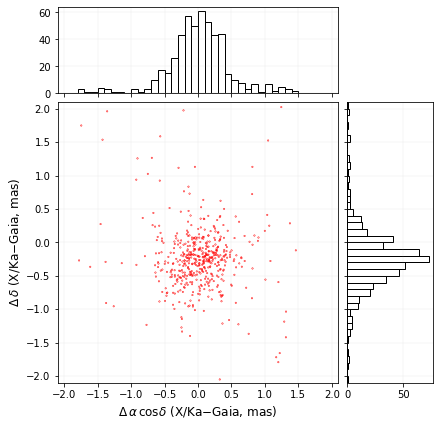

In [3]:
x, y = ka2g["dra"], ka2g["ddec"]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.12, 0.65
bottom, height = 0.12, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(6., 6.))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y, s=2, lw=0.5, facecolors="None", edgecolors="r")
axScatter.set_xlabel("$\Delta\,\\alpha\,\cos\delta$ (X/Ka$-$Gaia, mas)", fontsize=12)
axScatter.set_ylabel("$\Delta\,\delta$ (X/Ka$-$Gaia, mas)", fontsize=12)

# now determine nice limits by hand:
binwidth = 0.1
xymax = 2
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(x, bins=bins, fill=False)
axHisty.hist(y, bins=bins, orientation="horizontal", fill=False)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.grid(lw=0.1)
axHistx.grid(lw=0.1)
axHisty.grid(lw=0.1)

# plt.savefig("../plots/k-sx-scatter.eps", hbox="tight")

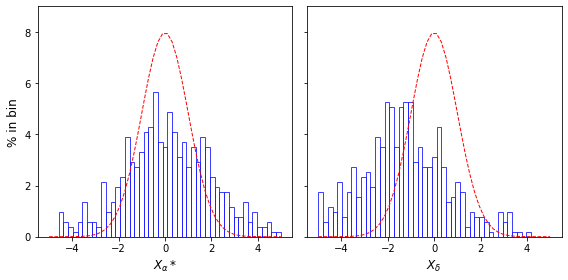

In [4]:
# Difference in RA and decl.
x, y = ka2g["nor_ra"], ka2g["nor_dec"]
bins_array = np.linspace(-5, 5, 50)
weights = np.ones(num_sou) * 100. / num_sou 

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2, sharey=True)
ax0.hist(x, bins_array, weights=weights, facecolor='w', alpha=0.75, edgecolor="b")
ax1.hist(y, bins_array, weights=weights, facecolor="w", edgecolor="b", alpha=0.75)

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 26, 2))
ax1.set_yticks(np.arange(0, 26, 2))

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_xlabel("$X_\\alpha*$", fontsize=12)
ax1.set_xlabel("$X_\\delta$", fontsize=12)

ax0.set_ylabel("% in bin", fontsize=12)
# ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

Text(0, 0.5, '% in bin')

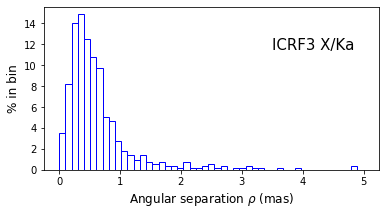

In [5]:
# Distribution of normalized separation
x = ka2g["ang_sep"]
bins_array = np.linspace(0, 5, 50)
weights = np.ones(num_sou) * 100. / num_sou

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(x, bins_array, weights=weights, 
        facecolor="w", edgecolor="b")

ax.text(3.5, 11.5, "ICRF3 X/Ka", fontsize=15)
# ax.set_xlim([0, 10])
ax.set_xlabel("Angular separation $\\rho$ (mas)", fontsize=12)
ax.set_ylabel("% in bin", fontsize=12)
# ax.grid()

Text(0, 0.5, '% in bin')

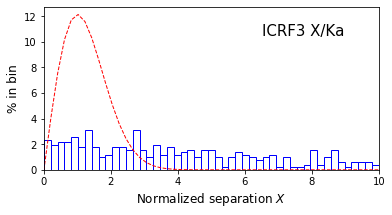

In [6]:
# Distribution of normalized separation
x = ka2g["nor_sep"]

bins_array = np.linspace(0, 10, 50)
weights = np.ones(num_sou) * 100. / num_sou

fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(x, bins_array, weights=weights, 
        facecolor="w", edgecolor="b")

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.text(6.5, 10.5, "ICRF3 X/Ka", fontsize=15)

ax.set_xlim([0, 10])
ax.set_xlabel("Normalized separation $X$", fontsize=12)
ax.set_ylabel("% in bin", fontsize=12)
# ax.grid()

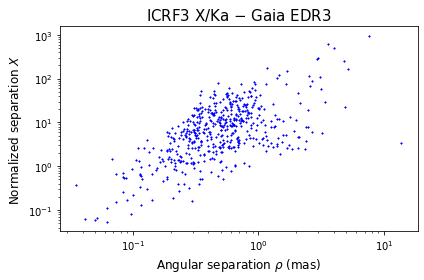

In [7]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(ka2g["ang_sep"], ka2g["nor_sep"], "b*", ms=1.5)

ax.set_ylabel("Normalized separation $X$", fontsize=12)
ax.set_xlabel("Angular separation $\\rho$ (mas)", fontsize=12)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_title('ICRF3 X/Ka $-$ Gaia EDR3', fontsize=15)

fig.tight_layout()

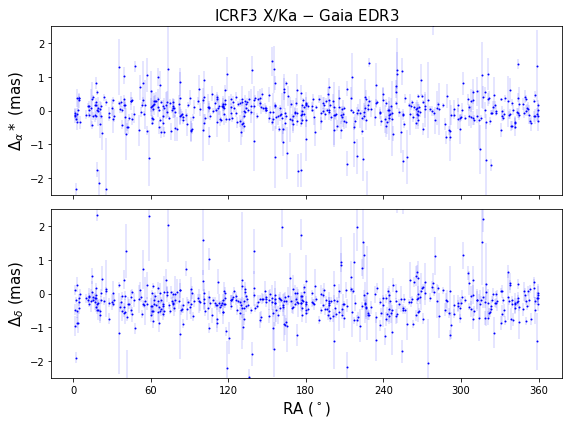

In [8]:
# Difference in RA and decl.
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True, sharey=True)

ax0.errorbar(ka2g['ra'], ka2g['dra'], yerr=ka2g['dra_err'],
             fmt='.', color='b', elinewidth=0.2, ms=2)
ax1.errorbar(ka2g['ra'], ka2g['ddec'], yerr=ka2g['ddec_err'],
             fmt='.', color='b', elinewidth=0.2, ms=2)

ax0.set_xticks(np.arange(0, 361, 60))

ax0.set_ylim([-2.5, 2.5])


ax1.set_xlabel('RA ($^\circ$)', fontsize=15)
ax0.set_ylabel('$\Delta_\\alpha*$ (mas)', fontsize=15)
ax1.set_ylabel('$\Delta_\\delta$ (mas)', fontsize=15)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
fig.tight_layout()

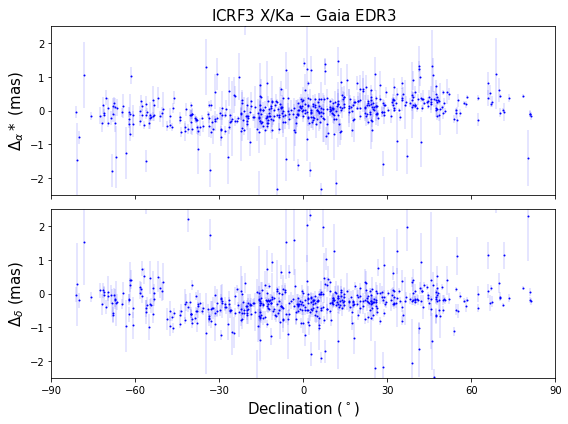

In [9]:
# Difference in RA and decl.
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True, sharey=True)

ax0.errorbar(ka2g['dec'], ka2g['dra'], yerr=ka2g['dra_err'],
             fmt='.', color='b', elinewidth=0.2, ms=2)
ax1.errorbar(ka2g['dec'], ka2g['ddec'], yerr=ka2g['ddec_err'],
             fmt='.', color='b', elinewidth=0.2, ms=2)

ax0.set_xticks(np.arange(-90, 91, 30))
ax0.set_xlim([-90, 90])
ax0.set_ylim([-2.5, 2.5])

ax1.set_xlabel('Declination ($^\circ$)', fontsize=15)
ax0.set_ylabel('$\Delta_\\alpha*$ (mas)', fontsize=15)
ax1.set_ylabel('$\Delta_\\delta$ (mas)', fontsize=15)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
fig.tight_layout()

I use four criteria to get a clean sample.

In [10]:
def vsh_fit(tab, key_list):
    
    # Transform column into np.array
    dra = np.array(tab[key_list[0]])
    ddec = np.array(tab[key_list[1]])
    dra_err = np.array(tab[key_list[2]])
    ddec_err = np.array(tab[key_list[3]])
    ra_rad = np.array(tab[key_list[4]].to(u.radian))
    dec_rad = np.array(tab[key_list[5]].to(u.radian))
    dra_ddec_cov = np.array(tab[key_list[6]])
    
    # Transformation parameters
    # l_max = 1
    w1, sig1, corrcoef1 = vsh_deg01_fitting(
        dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
        cov=dra_ddec_cov, elim_flag="None")

    # l_max = 2
    w2, sig2, corrcoef2 = vsh_deg02_fitting(
        dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
        cov=dra_ddec_cov, elim_flag="None")
    
    # mas -> uas
    w1sx = w1 * 1.e3
    sig1sx = sig1 * 1.e3
    w2sx = w2 * 1.e3
    sig2sx = sig2 * 1.e3

    # Print results
#     print("Position offset of SX - Gaia (all {:d} sources)".format(dra1.size))
    print("\nIn 'l_max=1' fit")
    print_vsh_result(w1sx, sig1sx, corrcoef1)

    print("\nIn 'l_max=2' fit")
    print_vsh_result(w2sx, sig2sx, corrcoef2)

Estimate the 6-parameter and 16-parameter and save them in text files.

In [11]:
# Print results
print("Position offset of X/Ka - Gaia (all {:d} sources)".format(len(ka2g)))

vsh_fit(ka2g, key_list=["dra", "ddec", "dra_err", "ddec_err", 
                        "ra", "dec", "dra_ddec_cov"])

Position offset of X/Ka - Gaia (all 512 sources)

In 'l_max=1' fit
VSH parameter Estimate Error
                uas     uas 
------------- -------- -----
           D1       16    22
           D2       -1    20
           D3     -331    22
           R1      -30    23
           R2      -38    22
           R3       55    19

Correlation coefficient
---------------------------------------------------------
          D1    D2    D3    R1    R2    R3
    D1  +1.0
    D2  +0.0  +1.0
    D3  -0.0  +0.0  +1.0
    R1  +0.1  +0.2  -0.1  +1.0
    R2  -0.2  +0.1  -0.0  -0.0  +1.0
    R3  +0.1  -0.0  -0.2  -0.1  -0.1  +1.0

In 'l_max=2' fit
VSH parameter Estimate Error
                uas     uas 
------------- -------- -----
           D1       -4    21
           D2       24    21
           D3     -353    21
           R1      -38    22
           R2      -34    22
           R3        9    18
         E22R       -4    11
         E22I        4    12
         E21R      -73    25
         E21

In [12]:
# R = np.array([-15, -29, 5])
# R_err = np.array([16, 15, 14])
# R1, R2 = R - R_err, R + R_err

# G = np.array([-8, 20, -344])
# G_err = np.array([15, 15, 15])
# G1, G2 = G - G_err, G + G_err

# EM = np.array([0, 12, -52, 72, 135, -5, 11, 12, 33, 227])
# EM_err = np.array([9, 9, 18, 20, 19, 10, 10, 19, 19, 16])
# EM1, EM2 = EM - EM_err, EM + EM_err

In [13]:
def outlier_elim(com_sou_sample, X0=1e8, rho0=1e8):
    """Eliminate the outliers.
    """

    # Remove the outlier (consider the normalized separation)
    N = len(com_sou_sample)
#     X0 = np.sqrt(np.log(N) * 2)

    mask = ((com_sou_sample["nor_sep"] <= X0)
            & (com_sou_sample["ang_sep"] < rho0))

    # Table of a clean sample
    cln_sou_sample = com_sou_sample[mask]
    N1 = len(cln_sou_sample)
    out_ratio = (N - N1) / N

    return cln_sou_sample, X0, N, N1, out_ratio

In [14]:
def vsh_estimate(tab, key_list):
    
    # Transform column into np.array
    dra = np.array(tab[key_list[0]])
    ddec = np.array(tab[key_list[1]])
    dra_err = np.array(tab[key_list[2]])
    ddec_err = np.array(tab[key_list[3]])
    ra_rad = np.array(tab[key_list[4]].to(u.radian))
    dec_rad = np.array(tab[key_list[5]].to(u.radian))
    dra_ddec_cov = np.array(tab[key_list[6]])

    # Transformation parameters
    # l_max = 2
    w2_all, sig2_all, corrcoef2_all = vsh_deg02_fitting(
        dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
        cov=dra_ddec_cov, elim_flag="None")

    # mas -> uas
    w2 = w2_all * 1.e3
    sig2 = sig2_all * 1.e3

    return w2, sig2

In [15]:
# Create an array of maximum g magnitude
X0_bin = np.arange(1, 50.1, 1)

# Write the output into several text file
# Statistics
# ICRF3 X/Ka
fsta3sx = open("../logs/X0-stat-icrf3xka-gaiaedr3-common.log", "w")
print("# X0  Nb_all  Nb_cln  outlier_rio", file=fsta3sx)

# VSH parameters
# ICRF3 K
fvsh3sx = open("../logs/X0-vsh02-icrf3xka-gaiaedr3-common.log", "w")
print("# X0  Glide(3)  Rotation(3)  Quadrupole(10)  +/-  \n"
      "# Unit: micro-arcsec", file=fvsh3sx)

parline = "{:+6.0f}  " * 16
errline = "{:6.0f}  " * 16

# Iterate in each bin to estimate the VSH parameters
for X0i in X0_bin:

    cln_sou_3sx, X0, N, N1, out_ratio = outlier_elim(ka2g, X0=X0i)

    w2, sig2 = vsh_estimate(cln_sou_3sx, key_list=["dra", "ddec", "dra_err", "ddec_err",
                                                   "ra", "dec", "dra_ddec_cov"])

    dra_med, ddec_med = median_oft_after_adjustment(ka2g, w2/1e3)

    print("{:5.2f}  {:5d}  {:5d}  {:.2f}  {:.3f}  {:.3f}".format(
        X0i, N, N1, out_ratio, dra_med, ddec_med), file=fsta3sx)
    print("{:5.2f}".format(X0i), parline.format(
        *w2), errline.format(*sig2), file=fvsh3sx)


# Close all the open files
fsta3sx.close()
fvsh3sx.close()

In [16]:
# Number of sources as a function of X0
X0_3sx, N0_3sx, N1_3sx, rate3sx, dra_med, ddc_med = np.genfromtxt(
    "../logs/X0-stat-icrf3xka-gaiaedr3-common.log", unpack=True)

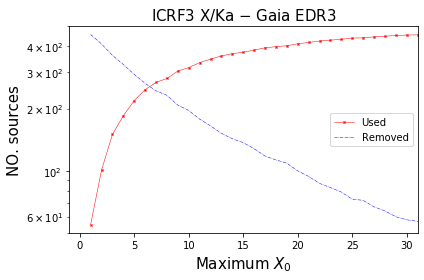

In [17]:
fig, ax1 = plt.subplots(figsize=(6, 4))

# Number of used sources
ax1.plot(X0_3sx, N1_3sx, "r-x", ms=2, lw=0.5, label="Used")
ax1.plot(X0_3sx, N0_3sx-N1_3sx, "b-.", ms=2, lw=0.5, label='Removed')

ax1.axis([-1, 31, 50, 500])
ax1.set_xlabel("Maximum $X_0$", fontsize=15)
ax1.set_ylabel("NO. sources", fontsize=15)
ax1.set_yscale("log")
ax1.legend()

plt.title('ICRF3 X/Ka $-$ Gaia EDR3', fontsize=15)
plt.tight_layout()

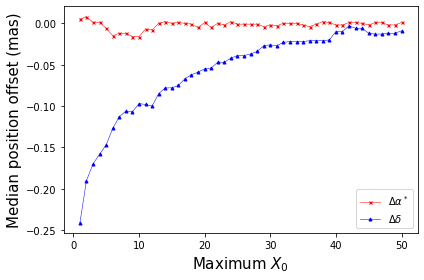

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))

# Number of used sources
ax.plot(X0_3sx, dra_med, "r-x", ms=3, lw=0.5, label="$\\Delta\\alpha^*$")
ax.plot(X0_3sx, ddc_med, "b-^", ms=3, lw=0.5, label="$\\Delta\\delta$")

# ax1.axis([-1, 31, 200, 3200])
ax.set_xlabel("Maximum $X_0$", fontsize=15)
ax.set_ylabel("Median position offset (mas)", fontsize=15)
# ax1.set_yscale("log")
ax.legend()
plt.tight_layout()

In [19]:
par3sx = np.genfromtxt("../logs/X0-vsh02-icrf3xka-gaiaedr3-common.log")

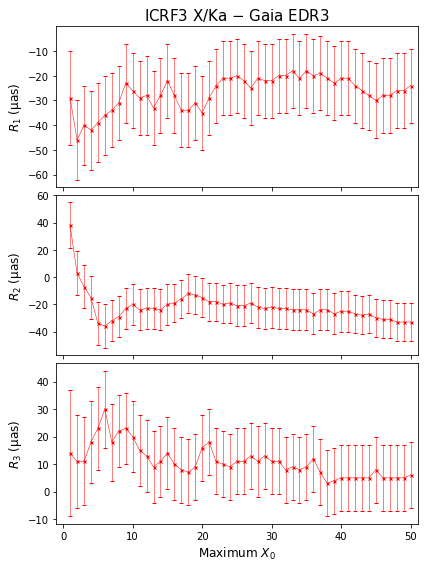

In [20]:
# --------------------- ROTATION -------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=3, sharex=True)

# ax0.fill_between(np.arange(-1, 52), R1[0], R2[0],color='blue',alpha=0.25)
# ax1.fill_between(np.arange(-1, 52), R1[1], R2[1],color='blue',alpha=0.25)
# ax2.fill_between(np.arange(-1, 52), R1[2], R2[2],color='blue',alpha=0.25)

# R1
ax0.errorbar(par3sx[:, 0], par3sx[:, 4], yerr=par3sx[:, 20],
             fmt="r-x", label="ICRF3 S/X", capsize=2, elinewidth=0.5, ms=3, lw=0.5)
# ax0.axis([17.4, 21.1, -80, 100])
ax0.set_ylabel("$R_1$ ($\mathrm{\mu}$as)", fontsize=12)
# ax0.grid()

# R2
ax1.errorbar(par3sx[:, 0], par3sx[:, 5], yerr=par3sx[:, 21],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax1.axis([17.4, 21.1, -75, 50])
ax1.set_ylabel("$R_2$ ($\mathrm{\mu}$as)", fontsize=12)
# ax1.grid()

# R3
ax2.errorbar(par3sx[:, 0], par3sx[:, 6], yerr=par3sx[:, 22],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax2.axis([17.4, 21.1, -75, 50])
ax2.set_xlabel("Maximum $X_0$", fontsize=12)
ax2.set_ylabel("$R_3$ ($\mathrm{\mu}$as)", fontsize=12)

ax0.set_xlim([-1, 51])
ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig("../plots/fig10.eps")
# plt.close()

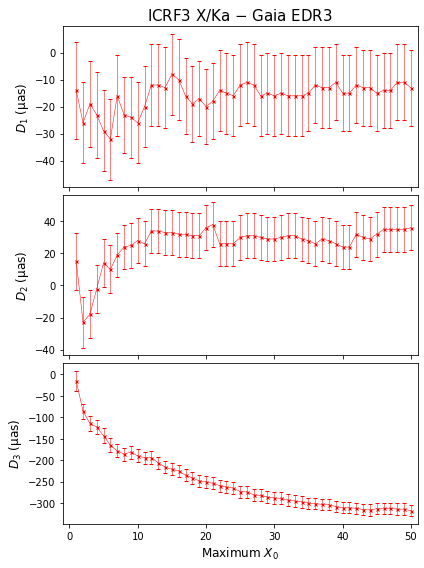

In [21]:
# --------------------- GLIDE -------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=3, sharex=True)

# ax0.fill_between(np.arange(-1, 52), G1[0], G2[0],color='blue',alpha=0.25)
# ax1.fill_between(np.arange(-1, 52), G1[1], G2[1],color='blue',alpha=0.25)
# ax2.fill_between(np.arange(-1, 52), G1[2], G2[2],color='blue',alpha=0.25)

# D1
ax0.errorbar(par3sx[:, 0], par3sx[:, 1], yerr=par3sx[:, 17],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax0.axis([17.4, 21.1, -110, 30])
ax0.set_ylabel("$D_1$ ($\mathrm{\mu}$as)", fontsize=12)
# ax0.grid()

# D2
ax1.errorbar(par3sx[:, 0], par3sx[:, 2], yerr=par3sx[:, 18],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax1.axis([17.4, 21.1, -40, 200])
ax1.set_ylabel("$D_2$ ($\mathrm{\mu}$as)", fontsize=12)
# ax1.grid()

# D3
ax2.errorbar(par3sx[:, 0], par3sx[:, 3], yerr=par3sx[:, 19],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax2.axis([17.4, 21.1, -250, 330])
ax2.set_xlabel("Maximum $X_0$", fontsize=12)
ax2.set_ylabel("$D_3$ ($\mathrm{\mu}$as)", fontsize=12)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
ax0.set_xlim([-1, 51])
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig("../plots/glide-on-g.eps")
# plt.close()

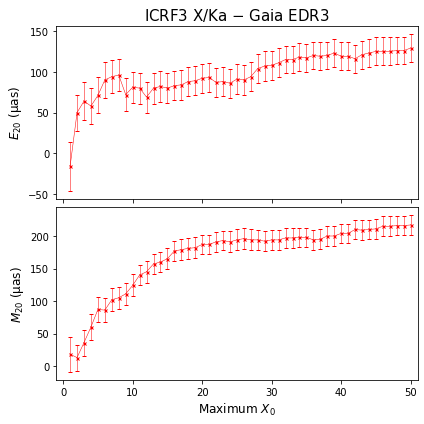

In [22]:
# E20 and M20
# E20
fig, (ax0, ax1) = plt.subplots(figsize=(6, 6), nrows=2, sharex=True)

# ax0.fill_between(np.arange(-1, 52), EM1[4], EM2[4],color='blue',alpha=0.25)
# ax1.fill_between(np.arange(-1, 52), EM1[9], EM2[9],color='blue',alpha=0.25)

ax0.errorbar(par3sx[:, 0], par3sx[:, 11], yerr=par3sx[:, 27],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax0.set_xlim([17.4, 21.1])
# ax0.set_ylim([-140, 210])
ax0.set_ylabel("$E_{20}$ ($\mathrm{\mu}$as)", fontsize=12)

# M20
ax1.errorbar(par3sx[:, 0], par3sx[:, 16], yerr=par3sx[:, 32],
             fmt="r-x", label="ICRF3 S/X", capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax1.axis([17.4, 21.1, -70, 200])
ax1.set_xlabel("Maximum $X_0$", fontsize=12)
ax1.set_ylabel("$M_{20}$ ($\mathrm{\mu}$as)", fontsize=12)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
ax0.set_xlim([-1, 51])

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

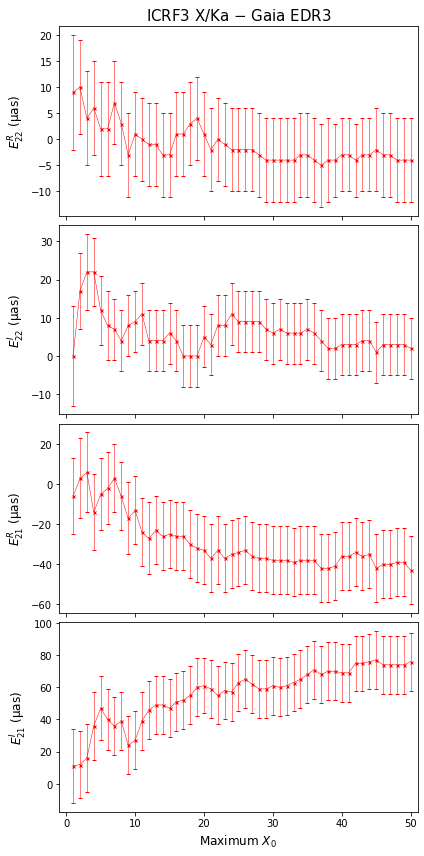

In [23]:
# M^{I,R}_2{1,2}
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(6, 12), nrows=4, sharex=True)

# ax0.fill_between(np.arange(-1, 52), EM1[0], EM2[0],color='blue',alpha=0.25)
# ax1.fill_between(np.arange(-1, 52), EM1[1], EM2[1],color='blue',alpha=0.25)
# ax2.fill_between(np.arange(-1, 52), EM1[2], EM2[2],color='blue',alpha=0.25)
# ax3.fill_between(np.arange(-1, 52), EM1[3], EM2[3],color='blue',alpha=0.25)

# ER22
ax0.errorbar(par3sx[:, 0], par3sx[:, 7], yerr=par3sx[:, 23],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax0.axis([17.4, 21.1, -50, 30])
ax0.set_ylabel("$E^R_{22}$ ($\mathrm{\mu}$as)", fontsize=12)

# ax0.grid()
# ax0.legend(fontsize="x-small")

# EI22
ax1.errorbar(par3sx[:, 0], par3sx[:, 8], yerr=par3sx[:, 24],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax1.axis([17.4, 21.1, -30, 50])
ax1.set_ylabel("$E^I_{22}$ ($\mathrm{\mu}$as)", fontsize=12)


# ax1.grid()
# ax1.legend(fontsize="x-small")

# ER21
ax2.errorbar(par3sx[:, 0], par3sx[:, 9], yerr=par3sx[:, 25],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax2.axis([17.4, 21.1, -150, 50])
ax2.set_ylabel("$E^R_{21}$ ($\mathrm{\mu}$as)", fontsize=12)


# EI21
ax3.errorbar(par3sx[:, 0], par3sx[:, 10], yerr=par3sx[:, 26],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax3.axis([17.4, 21.1, -120, 120])
ax3.set_xlabel("Maximum $X_0$", fontsize=12)
ax3.set_ylabel("$E^I_{21}$ ($\mathrm{\mu}$as)", fontsize=12)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
ax0.set_xlim([-1, 51])
# ax3.grid()
# ax3.legend(fontsize="x-small")

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig("../plots/vsh02-E-on-g.eps")
# plt.close()

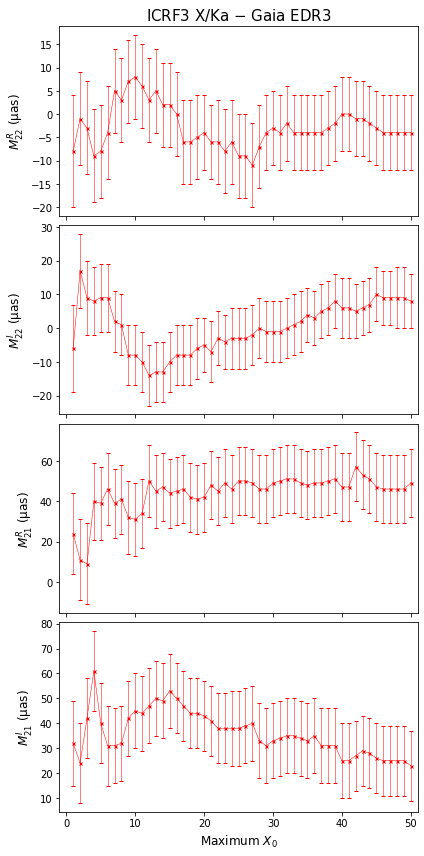

In [24]:
# M^{I,R}_2{1,2}
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(6, 12), nrows=4, sharex=True)

# ax0.fill_between(np.arange(-1, 52), EM1[5], EM2[5],color='blue',alpha=0.25)
# ax1.fill_between(np.arange(-1, 52), EM1[6], EM2[6],color='blue',alpha=0.25)
# ax2.fill_between(np.arange(-1, 52), EM1[7], EM2[7],color='blue',alpha=0.25)
# ax3.fill_between(np.arange(-1, 52), EM1[8], EM2[8],color='blue',alpha=0.25)

# ER22
ax0.errorbar(par3sx[:, 0], par3sx[:, 12], yerr=par3sx[:, 28],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

ax0.set_ylabel("$M^R_{22}$ ($\mathrm{\mu}$as)", fontsize=12)

# EI22
ax1.errorbar(par3sx[:, 0], par3sx[:, 13], yerr=par3sx[:, 29],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

ax1.set_ylabel("$M^I_{22}$ ($\mathrm{\mu}$as)", fontsize=12)

# ER21
ax2.errorbar(par3sx[:, 0], par3sx[:, 14], yerr=par3sx[:, 30],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

ax2.set_ylabel("$M^R_{21}$ ($\mathrm{\mu}$as)", fontsize=12)

# EI21
ax3.errorbar(par3sx[:, 0], par3sx[:, 15], yerr=par3sx[:, 21],
             fmt="r-x", label="ICRF3 S/X", 
             capsize=2, lw=0.5, elinewidth=0.5, ms=3)

# ax3.axis([17.4, 21.1, -120, 120])
ax3.set_xlabel("Maximum $X_0$", fontsize=12)
ax3.set_ylabel("$M^I_{21}$ ($\mathrm{\mu}$as)", fontsize=12)

ax0.set_title("ICRF3 X/Ka $-$ Gaia EDR3", fontsize=15)
ax0.set_xlim([-1, 51])
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
# plt.savefig("../plots/vsh02-M-on-g.eps")
# plt.close()